In [1]:
import numpy as np
import pandas as pd
import gdal
import matplotlib.pyplot as plt 

## 1d array shapelet method and example

In [2]:
# define ts
ts = [0.9, 0.89, 0.89, 0.76, 0.43, 0.32, 0.2, 0.19,
      0.19, 0.19, 0.19, 0.19, 0.19, 0.19, 0.19, 0.16, 0.19, 0.32, 0.47,0.5]
ts2 = [0.84, 0.85, 0.84, 0.86, 0.84, 0.86, 0.85, 0.86,
      0.75, 0.71, 0.71, 0.71, 0.86, 0.85, 0.84, 0.83, 0.83, 0.83, 0.84,0.84]
# define width
w = 3

In [2]:

def shapelet(ts, w):
    
    l = len(ts)
    
    # construct candidate_shapelet list and candidate_nonshapelet list
    candidate_S_list = []
    candidate_N_list = []
    i = 0
    while i+(w-1) < l:
        #candidate_S_list.append(list(range(i, i+w)))
        #candidate_N_list.append([list(range(0, i)),list(range(i+w, l-w+2))])

        S_ind = [i, i+w-1]  # a moving window size =3
        # left non-shapelet segment

        if i > 0:
            N1_ind = [0, i-1]
        else:
            N1_ind = []

        if i+w < l:
            N2_ind = [i+w, l-1]
        else:
            N2_ind = []

        candidate_S_list.append(S_ind) # like [[s1_start, s1_end], [s2_start, s2_end] ...]
        candidate_N_list.append([N1_ind, N2_ind])  # like [[[N_left1_start, N_left1_end], [N_right1_start, N_right1_end]], [[N_left2_start, N_left2_end], [N_right2_start, N_right2_end]]]
        i += 1

    # calculate GAP
    GAP_list = []
    
    # T test (T test 1: S and N1; T test 2: S and N2)
    t_val1_list = [] 
    t_val2_list = [] 
    
    
    for i in range(0,len(candidate_S_list)):
        S = ts[candidate_S_list[i][0]:candidate_S_list[i][1]+1]
        S_sd = np.std(S)
        S_mean = np.mean(S)
        
        N_sd_list = []
        # loop to inlucde N1 and N2
        for N_ind in candidate_N_list[i]:
            if N_ind != []:
                N = ts[N_ind[0]:N_ind[1]+1]
                N_sd_list.append(np.std(N))                
        # calculate GAP
        N_mean_sd = np.mean(N_sd_list) # the mean of two sd
        GAP = S_sd - N_mean_sd
        GAP_list.append(GAP)
        

        
    GAP_list_sorted = np.argsort(GAP_list) # return index of the sorted list
    S_selected = GAP_list_sorted[-1]
    
    # calculate the t score for this selected S
    S_selected_mean = np.mean(ts[S_selected:S_selected+w])
    S_selected_var = np.var(ts[S_selected:S_selected+w])
       
    # if N1 is not empty    
    if S_selected > 0:
        N1_selected_mean = np.mean(ts[0:S_selected])
        N1_selected_var = np.var(ts[0:S_selected])

       # because we are not sure  N1_selected_mean -  S_selected_mean is positive or negative, we take abs
        numerator = np.absolute(N1_selected_mean - S_selected_mean) 
        denominator1_upper = np.absolute((S_selected)*N1_selected_var**2 - (w-1)*S_selected_var**2) 
        denominator1_lower = (S_selected+w-2)
        denominator1 = (denominator1_upper/denominator1_lower)**0.5  
        denominator2 = (1/w + 1/(S_selected))**0.5
        t1 =  numerator/(denominator1*denominator2) 
    else:
        t1 = -999
        
    # if N2 is not empty    
    if S_selected+w-1  < l:
        N2_selected_mean = np.mean(ts[S_selected+w:l-1])
        N2_selected_var = np.var(ts[S_selected+w:l-1])
        
        numerator = np.absolute(N2_selected_mean - S_selected_mean) 
        denominator1 = (np.absolute((l-w-1)*N2_selected_var**2 - (w-1)*S_selected_var**2) / (l-2))**0.5
        denominator2 = (1/w + 1/(l-w))**0.5
        t2 =  numerator/(denominator1*denominator2) 
    else:
        t2 = -999
    

    
    
    return([S_selected, t1, t2])

In [2]:
def shapelet_2d(ts_2d, w):
    
    l = ts_2d.shape[1]
    
    # construct candidate_shapelet list and candidate_nonshapelet list
    candidate_S_list = []
    candidate_N_list = []
    i = 0
    while i+(w-1) < l:
        #candidate_S_list.append(list(range(i, i+w)))
        #candidate_N_list.append([list(range(0, i)),list(range(i+w, l-w+2))])

        S_ind = [i, i+w-1]  # a moving window size =3
        
        # if left non-shapelet segment exists, return its index
        if i > 0:
            N1_ind = [0, i-1]
        # else, return empty list
        else:
            N1_ind = []

        # if right non-shapelet exists, return index
        if i+w < l:
            N2_ind = [i+w, l-1]
        # else, return empty index
        else:
            N2_ind = []

        candidate_S_list.append(S_ind)
        candidate_N_list.append([N1_ind, N2_ind])
        i += 1

    # calculate GAP
    GAP_list = []
    
    # T test (T test 1: S and N1; T test 2: S and N2)
    t_val1_list = [] 
    t_val2_list = [] 
    
    
    for i in range(0,len(candidate_S_list)):
        S = ts_2d[:, candidate_S_list[i][0]:candidate_S_list[i][1]+1]   # for all rows, slice on ts based on candidate_s list
        S_sd = np.std(S, axis=1)
        S_mean = np.mean(S, axis=1)
        N_sd_list = []
        # loop to inlucde N1 and N2
        for N_ind in candidate_N_list[i]:
            if N_ind != []:
                N = ts_2d[:, N_ind[0]:N_ind[1]+1]
                N_sd_list.append(np.std(N, axis=1))                
        # calculate GAP
        N_mean_sd = np.mean(N_sd_list, axis=0) # the mean of two sd
        GAP = S_sd - N_mean_sd
        GAP_list.append(GAP.tolist())
        
    
    GAP_list = np.array(GAP_list).transpose(1,0)
        
    GAP_list_sorted = np.argsort(GAP_list, axis=1) # return index of the sorted list
    
    S_selected = GAP_list_sorted[:,-1]  # the start time point for the selected Shapelet
    
    print('GAP done')
    
    print(len(S_selected))
    
    # S_selected is also the index for candidate_S_list
    S_selected_list = []
    j=0
    for i in S_selected:
        #print(test_ts[j,i:i+3])
        S_selected_list.append(ts_2d[j,i:i+w].tolist())
        j+=1
    S_selected_list = np.array(S_selected_list)



#     # N1.
#     j=0
#     N1_selected_list = []
#     for i in S_selected:
#         N_temp = np.full((1,l-w),np.nan)             # creat a 1d nan array, use the potential max length of N, should be l-w
#         N_temp[:1,:i] =  ts_2d[j, 0:i].tolist()  # populate na array with N, may has a nan tail if len(N) < l-w
#         N1_selected_list.append(N_temp.tolist()[0])

#     N1_selected_list = np.array(N1_selected_list)    

#     # N2.
#     j=0
#     N2_selected_list = []
#     for i in S_selected:
#         N_temp = np.full((1,l-w),np.nan)
#         N_temp[:1,:(l-i-w)] =  ts_2d[j, i+w:].tolist()
#         N2_selected_list.append(N_temp.tolist()[0])

#     N2_selected_list = np.array(N2_selected_list)    
    
    
    
    
#     # N1 and N2 together.
#     j=0
#     N1_selected_list = []
#     N2_selected_list = []
#     for i in S_selected:
#         N1_temp = np.full((1,l-w),np.nan)             # creat a 1d nan array, use the potential max length of N, should be l-w
#         N1_temp[:1,:i] =  ts_2d[j, 0:i].tolist()  # populate na array with N, may has a nan tail if len(N) < l-w
#         N1_selected_list.append(N1_temp.tolist()[0])
        
#         N2_temp = np.full((1,l-w),np.nan)
#         N2_temp[:1,:(l-i-w)] =  ts_2d[j, i+w:].tolist()
#         N2_selected_list.append(N2_temp.tolist()[0])

#     N1_selected_list = np.array(N1_selected_list)  
#     N2_selected_list = np.array(N2_selected_list) 
    
    
    
    
    
    # N1 and N2 together use pandas to coarse each row to have same length, faster than padding nan for each row.
    j=0
    N1_selected_list = []
    N2_selected_list = []
    for i in S_selected:
        N1_selected_list.append(ts_2d[j, 0:i].tolist())
        N2_selected_list.append(ts_2d[j, i+w:].tolist())

        
        
    N1_selected_list = pd.DataFrame(N1_selected_list).to_numpy()
    N2_selected_list = pd.DataFrame(N2_selected_list).to_numpy()
    
    
    
    
    # convert inconsistent length lists to pandas then to numpy
    #pd.DataFrame(a).to_numpy()


    def t_test_2d(S,N):
        # S is the shapelet_2d in m*w, where m is the number of rows (pixels) and l is the length of window 
        # N is the Non-shapelet, either on the left or right of the shapelet.  The shape is m*v, which v varies from 0 to l-w

        S_mean = np.mean(S, axis=1)
        S_var = np.var(S, axis=1)                    
        N_mean = np.nanmean(N, axis=1)
        N_var = np.nanvar(N, axis=1)

        # count number of non-nan value for each row in N
        n_count = np.count_nonzero(~np.isnan(N), axis=1).astype('float')
        n_count[n_count==0]=np.nan

       # because we are not sure  N1_selected_mean -  S_selected_mean is positive or negative, we take abs
        numerator = np.absolute(N_mean - S_mean)
        denominator1_upper = np.absolute((n_count-1)*N_var**2 + (w-1)*S_var**2) 
        denominator1_lower = (n_count+w-2)
        denominator1 = (denominator1_upper/denominator1_lower)**0.5  
        denominator2 = ((1/(n_count)) +1/w)**0.5
        t =  numerator/(denominator1*denominator2) 
        return(t)


    print('Start t score calculation')

    t1_score = t_test_2d(S_selected_list,N1_selected_list)
    t2_score = t_test_2d(S_selected_list,N2_selected_list)

    return(S_selected, t1_score, t2_score)

    
    


In [3]:
def linear_fit(periods, timeseries):
    # just format and add one column initialized at 1
    X_mat=np.vstack((np.ones(len(periods)), periods)).T
    
    # cf formula : linear-regression-using-matrix-multiplication
    tmp = np.linalg.inv(X_mat.T.dot(X_mat)).dot(X_mat.T)
    return tmp.dot(timeseries.T)[1] 

In [4]:
def wirte_grid(out_array, out_array_type, template_tiff_fn, out_name, out_dir):
 #$print("processing: " + out_name +".rst")
    #1. open template tif and get its crs and col/row info
    in_ds = gdal.Open(template_tiff_fn)
    #2. get band metadata
    in_ds_GeoTransform = in_ds.GetGeoTransform()
    in_ds_Projection = in_ds.GetProjection()
    temp_band = in_ds.GetRasterBand(1)
    cols = temp_band.XSize
    rows = temp_band.YSize
 
    #3. output the array to rst
    tif_driver = gdal.GetDriverByName('GTIFF')
    type_code = out_array_type#gdal_array.NumericTypeCodeToGDALTypeCode(in_array.dtype)
    out_ds = tif_driver.Create(out_dir+ '/' + out_name + ".tif", cols, rows,1,type_code) # here 1 means 1 band in the image,3 means integer datatype
    out_band = out_ds.GetRasterBand(1)

    out_band.WriteArray(out_array)

    out_ds.SetGeoTransform(in_ds_GeoTransform)
    out_ds.SetProjection(in_ds_Projection)
    
    

In [5]:
def extract_cropprob_and_write(out_array_type, in_BULCU, out_name, out_dir):
 #$print("processing: " + out_name +".rst")
    #1. open template tif and get its crs and col/row info
    in_ds = gdal.Open(in_BULCU)
    #read tif band
    all_probs = in_ds.ReadAsArray()
    crop_prob = all_probs[1::2,:]/65532 # select every other odd row
    num_band = crop_prob.shape[0]
    
    #2. get band metadata
    in_ds_GeoTransform = in_ds.GetGeoTransform()
    in_ds_Projection = in_ds.GetProjection()
    temp_band = in_ds.GetRasterBand(1)
    cols = temp_band.XSize
    rows = temp_band.YSize
 
    #3. output the array to rst
    tif_driver = gdal.GetDriverByName('GTIFF')
    type_code = out_array_type#gdal_array.NumericTypeCodeToGDALTypeCode(in_array.dtype)
    out_ds = tif_driver.Create(out_dir+ '/' + out_name + ".tif", cols, rows, num_band, type_code) # here 1 means 1 band in the image,3 means integer datatype
    
    
    for i in range(0, num_band):
        out_array = crop_prob[i]
        out_band = out_ds.GetRasterBand(i+1)
        out_band.WriteArray(out_array)

    out_ds.SetGeoTransform(in_ds_GeoTransform)
    out_ds.SetProjection(in_ds_Projection)

In [66]:
def shaplelet_analysis(bulcu_folder, grid_id, out_folder):
    fp = bulcu_folder+'/grid_'+grid_id+ '_BULCU.tif'
    dataset = gdal.Open(fp)
    image = dataset.ReadAsArray()
    
    image_cropprob = image[1::2,:]/65532 # select every other odd row
    row = image_cropprob.shape[1]
    col = image_cropprob.shape[2]
    band_num = image_cropprob.shape[0]
    
    image_cropprob_flat = image_cropprob.transpose(2,1,0).reshape(row*col,band_num)
    
    result = shapelet_2d(image_cropprob_flat,3)
    shapelet_image = result[0].reshape(col,row).transpose(1,0)
    
    ts_len = image_cropprob_flat.shape[1]
    time_step = np.arange(ts_len)

    a = linear_fit(time_step, image_cropprob_flat)
    a_image = a.reshape(col,row).transpose(1,0)

    a_image[a_image>-0.03] =0
    a_image[a_image<=-0.03] =1
    a_image[a_image==0] = np.nan

    shapelet_masked = shapelet_image*a_image
    shapelet_masked = np.nan_to_num(shapelet_masked, nan=-999)
    
    
    wirte_grid(a_image, 6, fp, 'a_image_grid' + grid_id, out_folder+'/a_image/')

    wirte_grid(shapelet_image, 3, fp, 'shapelet_image_grid' +grid_id, out_folder+'/shapelet/')

    wirte_grid(shapelet_masked, 3, fp, 'shapelet_image_masked_grid'+ grid_id, out_folder+'/masked_shapelet/')

    extract_cropprob_and_write(6, fp, 'BULCU_grid'+ grid_id+'_Cropprob_image', out_folder+'/Cropprob/')

In [80]:
shapelet(ts,3)

[2, 7.2171860371864645, 69.06589018824414]

In [99]:
shapelet(ts2,3)

[10, 106.59638084554159, 73.49241085841115]

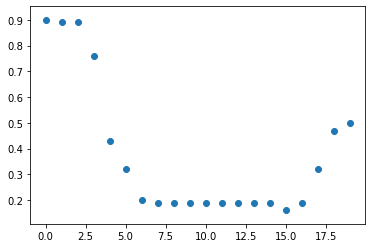

In [3]:

import matplotlib.pyplot as plt


plt.scatter(list(range(0,len(ts))), ts)
plt.show()

## 2d image shapelet example

In [49]:
fp = r'/media/sitian/TB/BULCU_project/example_BULCU_grid/grid_1020_BULCU.tif'
dataset = gdal.Open(fp)
image = dataset.ReadAsArray()

In [58]:
image_cropprob.shape

(16, 734, 872)

In [50]:
image_cropprob = image[1::2,:]/65532 # select every other odd row

In [51]:
image_cropprob_flat = image_cropprob.transpose(2,1,0).reshape(734*872,16)

In [ ]:
# run shapelt per pixel (5 minutes for a 734*872 grid)
# shapelet_ind = []
# t1 = []
# t2 = []
# for i in image_cropprob_flat:
#     shapelet_result = shapelet(i,3)
#     shapelet_ind.append(shapelet_result[0])
#     t1.append(shapelet_result[1])
#     t2.append(shapelet_result[2])

[[0, 2], [1, 3], [2, 4], [3, 5], [4, 6], [5, 7], [6, 8], [7, 9], [8, 10], [9, 11], [10, 12], [11, 13], [12, 14], [13, 15]]
[[[], [3, 15]], [[0, 0], [4, 15]], [[0, 1], [5, 15]], [[0, 2], [6, 15]], [[0, 3], [7, 15]], [[0, 4], [8, 15]], [[0, 5], [9, 15]], [[0, 6], [10, 15]], [[0, 7], [11, 15]], [[0, 8], [12, 15]], [[0, 9], [13, 15]], [[0, 10], [14, 15]], [[0, 11], [15, 15]], [[0, 12], []]]
[[0, 2], [1, 3], [2, 4], [3, 5], [4, 6], [5, 7], [6, 8], [7, 9], [8, 10], [9, 11], [10, 12], [11, 13], [12, 14], [13, 15]]
[[[], [3, 15]], [[0, 0], [4, 15]], [[0, 1], [5, 15]], [[0, 2], [6, 15]], [[0, 3], [7, 15]], [[0, 4], [8, 15]], [[0, 5], [9, 15]], [[0, 6], [10, 15]], [[0, 7], [11, 15]], [[0, 8], [12, 15]], [[0, 9], [13, 15]], [[0, 10], [14, 15]], [[0, 11], [15, 15]], [[0, 12], []]]
[[0, 2], [1, 3], [2, 4], [3, 5], [4, 6], [5, 7], [6, 8], [7, 9], [8, 10], [9, 11], [10, 12], [11, 13], [12, 14], [13, 15]]
[[[], [3, 15]], [[0, 0], [4, 15]], [[0, 1], [5, 15]], [[0, 2], [6, 15]], [[0, 3], [7, 15]], [[0, 

/tmp/ipykernel_181922/4132600789.py:75: RuntimeWarning: invalid value encountered in double_scalars
  t1 =  numerator/(denominator1*denominator2)
/home/sitian/miniconda3/envs/yieldmapping/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3583: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/sitian/miniconda3/envs/yieldmapping/lib/python3.8/site-packages/numpy/core/_methods.py:185: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(
/home/sitian/miniconda3/envs/yieldmapping/lib/python3.8/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


[[0, 2], [1, 3], [2, 4], [3, 5], [4, 6], [5, 7], [6, 8], [7, 9], [8, 10], [9, 11], [10, 12], [11, 13], [12, 14], [13, 15]]
[[[], [3, 15]], [[0, 0], [4, 15]], [[0, 1], [5, 15]], [[0, 2], [6, 15]], [[0, 3], [7, 15]], [[0, 4], [8, 15]], [[0, 5], [9, 15]], [[0, 6], [10, 15]], [[0, 7], [11, 15]], [[0, 8], [12, 15]], [[0, 9], [13, 15]], [[0, 10], [14, 15]], [[0, 11], [15, 15]], [[0, 12], []]]
[[0, 2], [1, 3], [2, 4], [3, 5], [4, 6], [5, 7], [6, 8], [7, 9], [8, 10], [9, 11], [10, 12], [11, 13], [12, 14], [13, 15]]
[[[], [3, 15]], [[0, 0], [4, 15]], [[0, 1], [5, 15]], [[0, 2], [6, 15]], [[0, 3], [7, 15]], [[0, 4], [8, 15]], [[0, 5], [9, 15]], [[0, 6], [10, 15]], [[0, 7], [11, 15]], [[0, 8], [12, 15]], [[0, 9], [13, 15]], [[0, 10], [14, 15]], [[0, 11], [15, 15]], [[0, 12], []]]
[[0, 2], [1, 3], [2, 4], [3, 5], [4, 6], [5, 7], [6, 8], [7, 9], [8, 10], [9, 11], [10, 12], [11, 13], [12, 14], [13, 15]]
[[[], [3, 15]], [[0, 0], [4, 15]], [[0, 1], [5, 15]], [[0, 2], [6, 15]], [[0, 3], [7, 15]], [[0, 

In [17]:
# restore the 1d output to 2d grid 
shapelet_image = np.array(shapelet_ind).reshape(872,734).transpose(1,0)
t1_image = np.array(t1).reshape(872,734).transpose(1,0)
t2_image = np.array(t2).reshape(872,734).transpose(1,0)

In [52]:
import time
start_time = time.time()
result = shapelet_2d(image_cropprob_flat,3)
print("--- %.2f seconds ---" % (time.time() - start_time))

GAP done
640048
Start t score calculation


/tmp/ipykernel_544156/139108045.py:147: RuntimeWarning: Mean of empty slice
  N_mean = np.nanmean(N, axis=1)
/tmp/ipykernel_544156/139108045.py:148: RuntimeWarning: Degrees of freedom <= 0 for slice.
  N_var = np.nanvar(N, axis=1)
/tmp/ipykernel_544156/139108045.py:160: RuntimeWarning: invalid value encountered in true_divide
  t =  numerator/(denominator1*denominator2)


--- 5.05 seconds ---


In [53]:
shapelet_image = result[0].reshape(872,734).transpose(1,0)


In [55]:
ts_len = image_cropprob_flat.shape[1]
time_step = np.arange(ts_len)

a = linear_fit(time_step, image_cropprob_flat)
a_image = a.reshape(872,734).transpose(1,0)

a_image[a_image>-0.03] =0
a_image[a_image<=-0.03] =1
a_image[a_image==0] = np.nan

shapelet_masked = shapelet_image*a_image
shapelet_masked = np.nan_to_num(shapelet_masked, nan=-999)

In [56]:
wirte_grid(shapelet_image, 3, fp, 'shapelet_image_grid1020', '/media/sitian/TB/BULCU_project/shapelet_analysis/')

wirte_grid(a_image, 6, fp, 'a_image_grid1020', '/media/sitian/TB/BULCU_project/shapelet_analysis/')
wirte_grid(shapelet_masked, 3, fp, 'shapelet_image_masked_grid1020', '/media/sitian/TB/BULCU_project/shapelet_analysis/')
#extract_cropprob_and_write(6, fp, 'BULCU_grid1020_Cropprob_image', '/media/sitian/TB/BULCU_project/shapelet_analysis/')

In [46]:
a = [[1,2,3],[4,5,6],[7,8]]

In [44]:
import pandas as pd

In [42]:
t1_image_0[100]

array([           nan, 4.18877039e+01, 4.18892727e+01, 4.18892727e+01,
       4.18892727e+01, 4.18892727e+01, 4.18877039e+01, 2.45535424e+01,
       1.45324149e+02, 1.45324149e+02, 1.45324149e+02, 1.45361328e+02,
       1.45361328e+02, 1.45361328e+02, 1.45088249e+02, 1.45088249e+02,
       1.45088249e+02, 1.45088249e+02, 1.45088249e+02, 1.45113304e+02,
       1.45088249e+02, 4.42940757e+01, 4.42940757e+01, 4.42940757e+01,
       4.42940757e+01, 4.42940757e+01, 2.31887403e+01, 8.87783024e+01,
       8.84097917e+01, 4.00822378e+01, 6.30089105e+01, 6.53233723e+01,
       1.47135151e+02, 1.47135151e+02, 1.47135151e+02, 1.47135151e+02,
       1.47135151e+02, 1.47135151e+02, 1.47135151e+02, 1.47135151e+02,
       3.45856339e+01, 3.45856339e+01, 3.45856339e+01, 5.14646739e+01,
       1.01496943e+02, 1.78168522e+02, 1.78168522e+02, 1.14526980e+02,
       7.63095463e+01, 7.81856926e+01, 6.12826535e+01, 2.43458833e+01,
       1.16604686e+02, 2.43458833e+01, 2.43458833e+01, 2.43458833e+01,
      

## Try grid 470

In [6]:
fp = r'/media/sitian/TB/BULCU_project/example_BULCU_grid/grid_470_BULCU.tif'
dataset = gdal.Open(fp)
image = dataset.ReadAsArray()
image_cropprob = image[1::2,:]/65532 # select every other odd row
image_cropprob_flat = image_cropprob.transpose(2,1,0).reshape(734*871,16) #871 for some reseaon, not 872

In [7]:
# calculate shapelet
result = shapelet_2d(image_cropprob_flat,3)
shapelet_image = result[0].reshape(871,734).transpose(1,0)

GAP done
639314
Start t score calculation


/tmp/ipykernel_544156/139108045.py:147: RuntimeWarning: Mean of empty slice
  N_mean = np.nanmean(N, axis=1)
/tmp/ipykernel_544156/139108045.py:148: RuntimeWarning: Degrees of freedom <= 0 for slice.
  N_var = np.nanvar(N, axis=1)
/tmp/ipykernel_544156/139108045.py:160: RuntimeWarning: invalid value encountered in true_divide
  t =  numerator/(denominator1*denominator2)


In [9]:
ts_len = image_cropprob_flat.shape[1]
time_step = np.arange(ts_len)

a = linear_fit(time_step, image_cropprob_flat)
a_image = a.reshape(871,734).transpose(1,0)

a_image[a_image>-0.03] =0
a_image[a_image<=-0.03] =1
a_image[a_image==0] = np.nan

shapelet_masked = shapelet_image*a_image
shapelet_masked = np.nan_to_num(shapelet_masked, nan=-999)

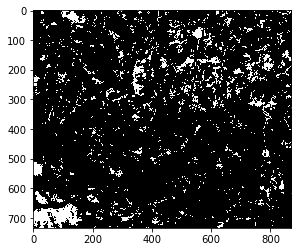

In [44]:
plt.imshow(shapeplet_masked, cmap="gray")

In [47]:
wirte_grid(a_image, 6, fp, 'a_image_grid470', '/media/sitian/TB/BULCU_project/shapelet_analysis/')

wirte_grid(shapelet_image, 3, fp, 'shapelet_image_grid470', '/media/sitian/TB/BULCU_project/shapelet_analysis/')

wirte_grid(shapelet_masked, 3, fp, 'shapelet_image_masked_grid470', '/media/sitian/TB/BULCU_project/shapelet_analysis/')

extract_cropprob_and_write(6, fp, 'BULCU_grid470_Cropprob_image', '/media/sitian/TB/BULCU_project/shapelet_analysis/')

## --------------------------------------

In [67]:
shaplelet_analysis('/media/sitian/TB/BULCU_project/example_BULCU_grid/', '1020', '/media/sitian/TB/BULCU_project/shapelet_analysis/')

GAP done
640048
Start t score calculation


/tmp/ipykernel_544156/139108045.py:147: RuntimeWarning: Mean of empty slice
  N_mean = np.nanmean(N, axis=1)
/tmp/ipykernel_544156/139108045.py:148: RuntimeWarning: Degrees of freedom <= 0 for slice.
  N_var = np.nanvar(N, axis=1)
/tmp/ipykernel_544156/139108045.py:160: RuntimeWarning: invalid value encountered in true_divide
  t =  numerator/(denominator1*denominator2)
